In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


## Looking at the HRF as a Gaussian process

The haemodynamic response function in BOLD fMRI is a impulse response to neural activity. Its characteristic shape can be described in a stylized manner as a difference of gamma functions, but in reality, not all HRFs adhere to that shape, and they vary significantly across the brain.

It thus becomes interesting to estimate the HRF. If event presentation times and measurement times can be placed on the same temporal grid (e.g. event presentation every 4 seconds, measurement every 2 seconds -> grid of 2 seconds), then one can attempt to estimate the HRF as a simple vector of entries covering a certain number of measurement points.

If the greatest common divisor of the event presentation and measurement grids is very small, then the HRF has to be oversampled strongly in order to accommodate both grids adequately. This necessitates more data and smoothness priors to be able to calculate a good estimate.

Taking one step further, one can assume the HRF to be an entirely continuous function, drawn from a distribution of functions. The usual choice of distribution on functions is the Gaussian Process distribution.

In [2]:
from nistats import hemodynamic_models

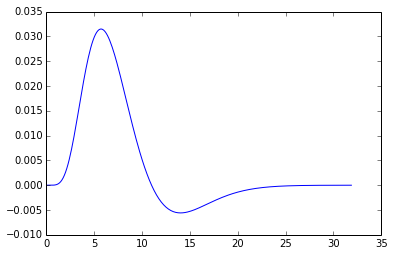

In [3]:
TR, oversampling, time_length = 2., 16., 32.
hrf = hemodynamic_models.glover_hrf(tr=TR, oversampling=oversampling)
plt.plot(np.arange(0., time_length, TR / oversampling), hrf)

## Estimating a Gaussian Process

The Gaussian process distribution is a distribution over functions such that when evaluated on a finite number of points, the covariance matrix of the function values is defined by a pairwise kernel function.

Differently put, a function $f:\mathbb{R}\rightarrow\mathbb{R}$ is a Gaussian process if for all $x\in\mathbb R$, $f(x)$ is a random variable and that for all $x_1, \dots, x_n\in\mathbb R$ the vector $(f(x_1), \dots, f(x_n))^T$ follows a Gaussian distribution with mean $(\mu(x_1), \dots, \mu(x_n))^T$ and covariance $K$ with $$K = \left(\begin{array}{cccc}k(x_1, x_1) & k(x_1, x_2) & \dots & k(x_1, x_n)\\\vdots & \ddots & {} & \vdots\\k(x_{n-1}, x_1) & {} & \ddots & {}\\k(x_n, x_1) & \dots & \dots & k(x_n, x_n)\end{array}\right),$$
where $k:\mathbb R^2\rightarrow\mathbb R$ is the covariance function or covariance kernel. It must be *positive definite*, which means that all covariance matrices it gives rise to must be positive semi-definite.

If this is the case, we can write
$$f\sim\mathcal{GP}(\mu, k)$$

So how does estimating one of these work? Well, measuring a Gaussian process, i.e. obtaining a function value, say in $x_1$, means that we know the value of the Gaussian random variable $f(x_1)$ to be e.g. $y_1$. Taking this information into account is thus equivalent to conditioning on $f(x_1) = y_1$. 

Now, a Gaussian distribution conditional to knowing some of its variable outcomes remains a Gaussian distribution, just with different parameters, and there is a closed form expression to obtain it.

Let $y\in\mathbb{R}^N\sim\mathcal N(\mu, \Sigma)$ and let the values of $y_0, \dots, y_{n-1}$ be known for $n < N$. Then what is the distribution of the remaining points? If we write $\Sigma^{11}$ to be the covariance matrix of $y^1 = (y_0, \dots, y_{n-1})$, $\Sigma^{22}$ to be the covariance matrix of $y^2 = (y_n, \dots, y_{N-1})$ and $\Sigma^{21}$ to be the cross-covariance between the two, then we can write
$$\Sigma = \left(\begin{array}{c|c}\Sigma^{11} & {\Sigma^{21}}^T\\\hline\Sigma^{21}&\Sigma^{22}\end{array}\right)$$
If we further let $\mu^1 = (\mu_0,\dots, \mu_{n-1})^T$ and $\mu^2 = (\mu_n,\dots,\mu_{N-1})^T$, then 
$$y_2\big|\{y_1 = a\}\sim \mathcal N(\bar\mu, \bar\Sigma)$$
with $$\bar \mu = \mu^2 - \Sigma^{21}{\Sigma^{11}}^{-1}(\mu^1 - a)$$ and 
$$\bar\Sigma = \Sigma^{22} - {\Sigma^{21}}^T{\Sigma^{11}}^{-1}\Sigma^{21}$$

This extends immediately to our Gaussian process setting, since all the points we will ever look at are going to be finite in number.

### A minimal GP estimation example
Let's take $f(x) = \sin(x)$

In [4]:
def f(x):
    return np.sin(x)

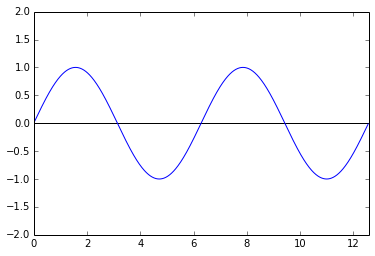

In [7]:
xs = np.arange(0, 4 * np.pi, 0.01)
ys = f(xs)

plt.plot(xs, ys)
plt.axis([0, 4 * np.pi, -2, 2])
plt.hlines([0], 0, 4 * np.pi)

Now lets measure this function in a finite number of random points

[0, 12.566370614359172, -2, 2]

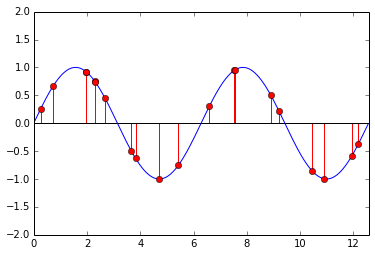

In [11]:
rng = np.random.RandomState(42)
xms = rng.uniform(0, 4 * np.pi, 20)
ms = f(xms)
plt.plot(xs, ys, 'b')
plt.plot(xms, ms, 'ro')
for xm, m in zip(xms, ms):
    plt.vlines([xm], 0, m, 'r')
plt.hlines([0], 0, 4 * np.pi)
plt.axis([0, 4 * np.pi, -2, 2])

For our Gaussian process distribution let's assume a zero mean $\mu = 0$ for simplicity. Let us further choose a covariance kernel that encodes smoothness, such as a simple Gaussian kernel with kernel width represented by a hyperparameter $\gamma$:
$$k_\gamma(x, y) = \exp\left(-\frac{1}{\gamma}\|y - x\|^2\right)$$

Let us define this kernel as a python function such that it can be evaluated on several points at once and plot the similarity matrices

In [12]:
def k(xs, ys, gamma=1.):
    xs, ys = map(np.atleast_1d, (xs, ys))
    diffs_squared = (xs.reshape(-1, 1) - ys.reshape(-1)) ** 2
    return np.exp(-diffs_squared / gamma)

(-0.5, 1256.5, 1256.5, -0.5)

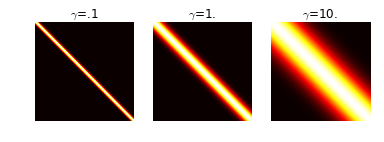

In [24]:
sim1 = k(xs, xs, gamma=.1)
sim2 = k(xs, xs, gamma=1.)
sim3 = k(xs, xs, gamma=10.)
plt.subplot(1, 3, 1)
plt.imshow(sim1)
plt.title('$\gamma$=.1')
plt.axis('off')
plt.hot()
plt.subplot(1, 3, 2)
plt.imshow(sim2)
plt.title('$\gamma$=1.')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(sim3)
plt.title('$\gamma$=10.')
plt.axis('off')

Let us apply the Gaussian conditioning as follows:
1. Let's take as $y_0, \dots, y_{n-1}$ the known function values, indicated by the red dots, ie the `ms` measured in `xms`.
2. Let's take as $y_n, \dots, y_N$ the function evaluated on an arbitrarily fine sampling grid, which we would like to plot the function with, e.g. the `xs`
3. We can then do a prediction using the mean of the conditional distribution
4. We have an estimate of the variance of the function measurements by looking at the diagonal of the conditional covariance matrix

In [51]:
gamma = 1.
n = len(xms)
all_xs = np.concatenate([xms, xs])
N = len(all_xs)
Sigma = k(all_xs, all_xs, gamma=gamma)
Sigma_11 = Sigma[:n, :n]
Sigma_22 = Sigma[n:, n:]
Sigma_21 = Sigma[n:, :n]
mu_bar = np.dot(Sigma_21, np.linalg.inv(Sigma_11)).dot(ms)
Sigma_bar = Sigma_22 - Sigma_21.dot(np.linalg.inv(Sigma_11)).dot(Sigma_21.T)

/home/parietal/eickenbe/software/python_pkg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


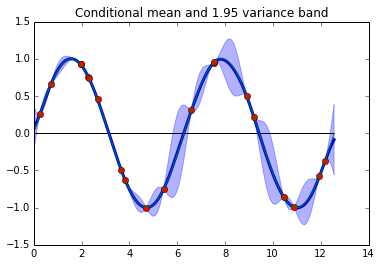

In [59]:
plt.plot(xs, mu_bar, 'b', lw=3)
plt.plot(xms, ms, 'ro')
plt.plot(xs, ys, 'g', lw=1)
plt.hlines([0], xs.min(), xs.max())
std = np.sqrt(np.diag(Sigma_bar))
plt.fill_between(xs, mu_bar + 1.95 * std, mu_bar - 1.95 * std, color=(0.,0., 1., .3))
plt.title('Conditional mean and 1.95 variance band')

That doesn't look too bad. As a matter of fact, the green line, representing the true function `f` isn't even visible because the conditional mean fits so well. This is a stroke of luck however, since by chance the width of the kernel corresponds somewhat to the with of variation of our sinusoid. We can observe a degradation if we vary `gamma`. In order to do this a little systematically, let's write the mean-variance predictor as a function and restrict ourselves to outputting only the diagonal of the conditional covariance

In [ ]:
def mean_variance_predict(x_train, y_train, x_test, kernel):
    all_xs = np.concatenate([x_train.ravel(), x_test.ravel()])
    n = len(x_train.ravel())
    Sigma = kernel(all_xs, all_xs)
    Sigma_11 = Sigma[:n, :n]
    Sigma_22 = Sigma[n:, n:]
    Sigma_21 = Sigma[n:, :n]
    